In [1]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans

In [4]:
iris = datasets.load_iris()
X= iris.data
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

In [5]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)
     

In [6]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [7]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])

    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_

    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
    return clusters

In [15]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype = np.float64)
    gamma_nk = np.zeros((N, K), dtype = np.float64)

    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']

        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()

    totals = np.sum(gamma_nk, 1)
    gamma_nk /=  np.expand_dims(totals, 1)

In [16]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])

    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)

        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis =0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k

        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [17]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [18]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []

        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k':cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
        history.append(clusters_snapshot)

        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i+1, 'Likelihood: ', likelihood)
    scores = np.log(gamma_nk)
    return clusters, likelihoods, scores, sample_likelihoods, history

In [19]:
n_clusters = 3
n_epochs = 40

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)


Epoch:  1 Likelihood:  -727.7880991223876
Epoch:  2 Likelihood:  -229.33102066299756
Epoch:  3 Likelihood:  -199.74812877963757
Epoch:  4 Likelihood:  -195.73888520322572
Epoch:  5 Likelihood:  -192.39610102342948
Epoch:  6 Likelihood:  -189.9948025598058
Epoch:  7 Likelihood:  -188.36696982597576
Epoch:  8 Likelihood:  -187.12218440393463
Epoch:  9 Likelihood:  -185.9688827396131
Epoch:  10 Likelihood:  -184.90274085547037
Epoch:  11 Likelihood:  -183.9615964160234
Epoch:  12 Likelihood:  -183.1229996094661
Epoch:  13 Likelihood:  -182.4217514935859
Epoch:  14 Likelihood:  -181.85314289768112
Epoch:  15 Likelihood:  -181.2745330260876
Epoch:  16 Likelihood:  -180.67059402382142
Epoch:  17 Likelihood:  -180.34032123839046
Epoch:  18 Likelihood:  -180.23332341934025
Epoch:  19 Likelihood:  -180.20041209371257
Epoch:  20 Likelihood:  -180.19017245247898
Epoch:  21 Likelihood:  -180.1869625954723
Epoch:  22 Likelihood:  -180.18594920021087
Epoch:  23 Likelihood:  -180.1856275629949
Epoch:

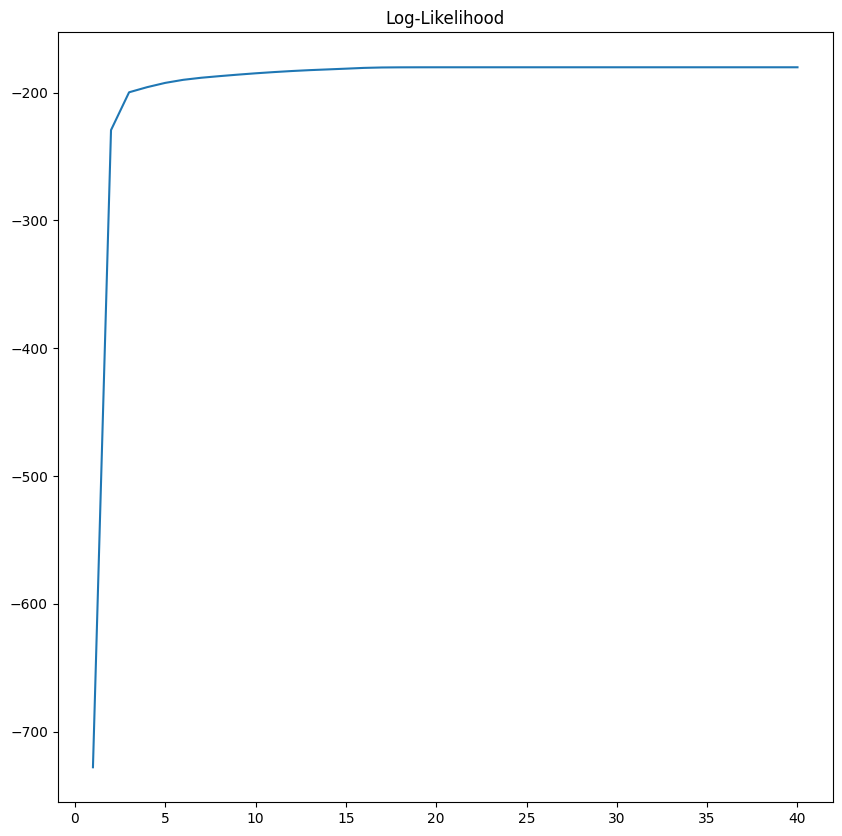

In [20]:
plt.figure(figsize = (10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

/tmp/ipykernel_31107/3567161413.py:40: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


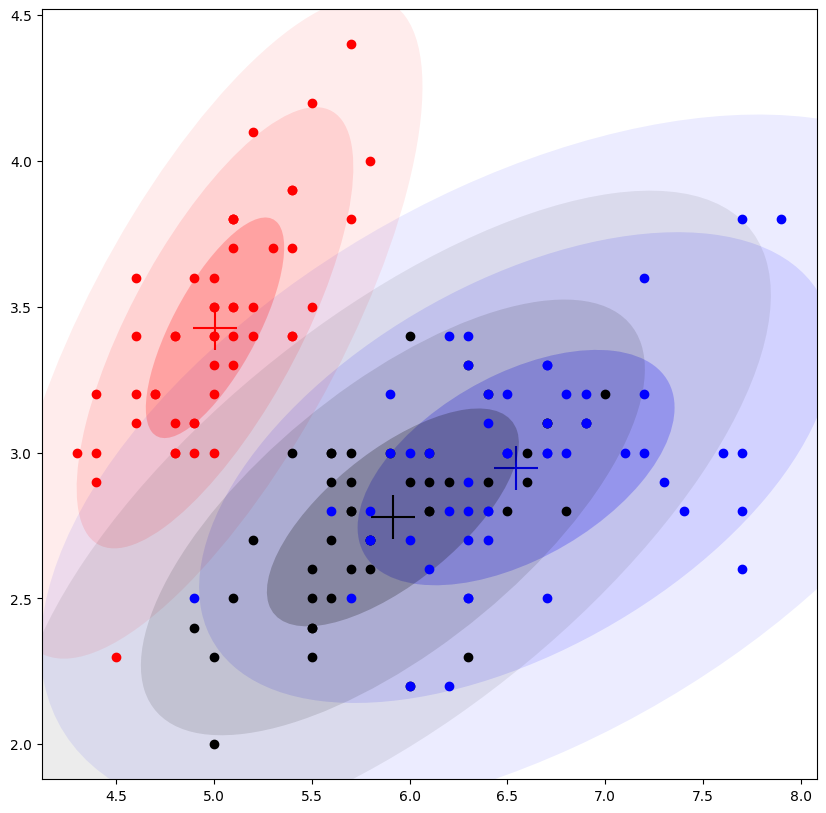

In [21]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

In [22]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)

print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[6.54639415 2.94946365 5.48364578 1.98726565]
 [5.006      3.428      1.462      0.246     ]
 [5.9170732  2.77804839 4.20540364 1.29848217]]
Means by our implementation:
 [[6.54454866 2.94866115 5.47955345 1.98460496]
 [5.006      3.428      1.462      0.246     ]
 [5.9149696  2.77784365 4.20155324 1.29696686]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


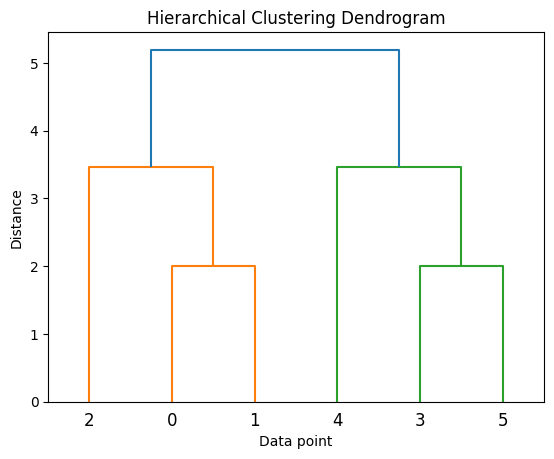

In [23]:
import numpy as np 
from scipy.cluster.hierarchy import dendrogram, linkage 
import matplotlib.pyplot as plt 
  
# randomly chosen dataset 
X = np.array([[1, 2], [1, 4], [1, 0], 
              [4, 2], [4, 4], [4, 0]]) 
  
# Perform hierarchical clustering 
Z = linkage(X, 'ward') 
  
# Plot dendrogram 
dendrogram(Z) 
  
plt.title('Hierarchical Clustering Dendrogram') 
plt.xlabel('Data point') 
plt.ylabel('Distance') 
plt.show()

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

N = 100

true_mean_0 = 1
true_mean_1 = 3
true_mean_2 = 5

true_precision_0 = 10
true_precision_1 = 10
true_precision_2 = 10

def sample(component):
    if component == 0:
        return np.random.normal(true_mean_0, np.sqrt(1 / true_precision_0), 1)[0]
    elif component == 1:
        return np.random.normal(true_mean_1, np.sqrt(1 / true_precision_1), 1)[0]
    else:
        return np.random.normal(true_mean_2, np.sqrt(1 / true_precision_2), 1)[0]

mask = np.random.choice([0, 1, 2], N, p=[0, 0, 1])
data = [sample(i) for i in mask]

df = pd.DataFrame(data)
df.to_csv('data.csv', sep=',', header = False, index = False)

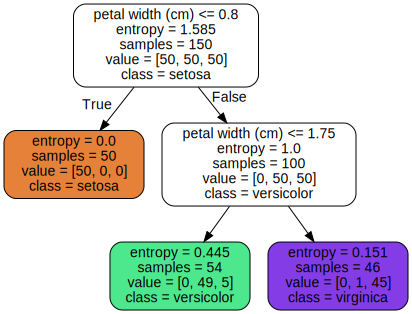

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)

tree_clf.fit(X, y)

export_graphviz(
    tree_clf,
    out_file = 'iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
 )
 
with open("iris_tree.dot") as f:
    dot_graph = f.read()
     
Source(dot_graph)

In [3]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from graphviz import Source

In [8]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [9]:
tree_reg = DecisionTreeRegressor(criterion = 'squared_error', max_depth = 2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

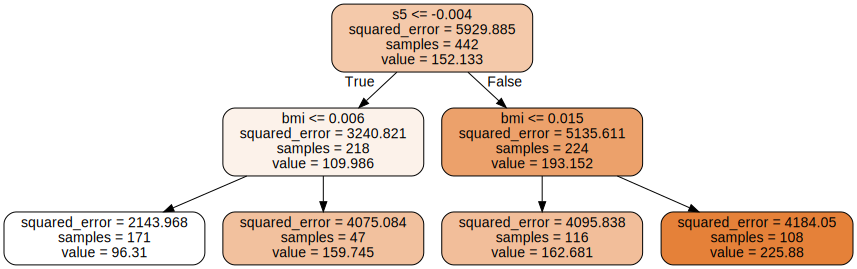

In [21]:
export_graphviz(
    tree_reg,
    out_file = 'diabetes_tree.dot',
    feature_names = diabetes.feature_names,
    class_names = diabetes.target,
    fontname = 'helvetica',
    rounded = True,
    filled = True
)
with open('diabetes_tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)

[0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0]
31
39
Gini:  0.4934693877551021
Accuracy is:  0.9


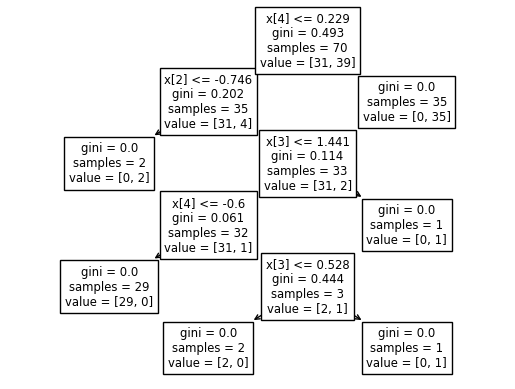

In [22]:
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split

X, t = make_classification(100, 5, n_classes=2, shuffle= True, random_state = 10)
X_train, X_test, t_train, t_test = train_test_split(
    X, t, test_size = 0.3, shuffle = True, random_state = 1)

model = tree.DecisionTreeClassifier()
model = model.fit(X_train, t_train)

predicted_value = model.predict(X_test)
print(predicted_value)

tree.plot_tree(model)

zeros = 0
ones = 0
for i in range(0, len(t_train)):
    if t_train[i] == 0:
        zeros += 1
    else:
        ones += 1

print(zeros)
print(ones)

val = 1 - ((zeros/70)*(zeros/70) + (ones/70)*(ones/70))
print('Gini: ', val)

match = 0
UnMatch = 0

for i in range(30):
    if predicted_value[i] == t_test[i]:
        match += 1
    else:
        UnMatch += 1

accuracy = match/30
print('Accuracy is: ', accuracy)
